# Modelos de Machine Learning

Nesse capítulo vamos ver as maneiras de usar modelos de Machine Learning para
forecasting. Aqui é onde mais acontecem erros de novos praticantes, pois
muitas vezes tentam aplicar modelos de ML diretamente na série temporal.


Para usar um modelo de ML, precisamos transformar a série temporal em um problema de regressão tradicional. Isso é feito criando janelas deslizantes (sliding windows) da série temporal, onde cada janela é usada como uma amostra de treinamento para o modelo de ML.

Ou seja, se temos uma série temporal $(y_t)$, podemos criar janelas de tamanho $n$ e usar os valores $y_{t-n}, y_{t-n+1}, \ldots, y_{t-1}$ como características (features) para prever o valor $y_t$.

![img/reduction.png](img/reduction.png)


Para prever mais de um passo à frente, existem duas abordagens:

1. **Previsão recursive**: se queremos prever $h$ passos à frente, podemos usar o modelo para prever $y_{t+1}$, depois usar essa previsão para prever $y_{t+2}$, e assim por diante, até $y_{t+h}$. Isso pode levar a erros acumulados, pois cada previsão depende das previsões anteriores.
2. **Previsão direta**: em vez de prever um passo de cada vez, podemos treinar o modelo para prever todos os $h$ passos à frente de uma vez. Isso pode ser feito usando um modelo para cada $h$ ou usando um modelo que prevê um vetor de $h$ valores.

A verdade é que as duas abordagens podem ser vistas como uma: a previsão recursiva pode ser vista como uma previsão direta para $h=1$.

In [1]:
# | echo: false

import warnings
warnings.filterwarnings("ignore")

In [2]:
# | code-fold: true
from tsbook.datasets.retail import SyntheticRetail
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster

dataset = SyntheticRetail("univariate")
y_train, X_train, y_test, X_test = dataset.load(
    "y_train", "X_train", "y_test", "X_test"
)

## O problema da tendência

A tendência em séries temporais é como um constante problema de data drift:

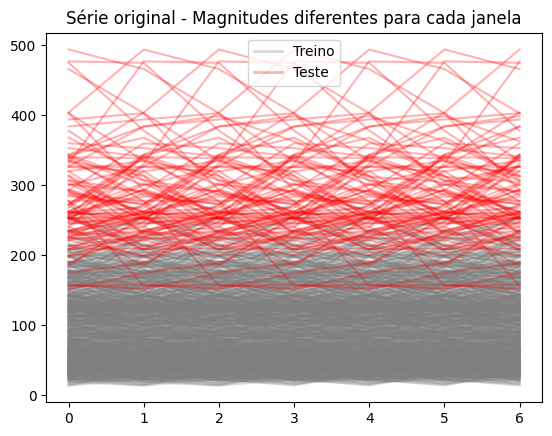

In [3]:
# | code-fold: true
_X = [y_train.iloc[i : i + 7] for i in range(0, 700)]

_X_test = [y_train.iloc[i : i + 7] for i in range(700, 800)]


def set_index(x):
    x.index = range(len(x))
    return x


_X = [set_index(x) for x in _X]
_X_test = [set_index(x) for x in _X_test]

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for x in _X:
    ax.plot(x, color="gray", alpha=0.3)
for x in _X_test:
    ax.plot(x, color="red", alpha=0.3)

# Add legend, with 1 red line for test and 1 gray for train
from matplotlib.lines import Line2D

legend_handles = [
    Line2D([0], [0], color="gray", alpha=0.3, lw=2, label="Treino"),
    Line2D([0], [0], color="red", alpha=0.3, lw=2, label="Teste"),
]
ax.legend(handles=legend_handles, loc="best")
ax.set_title("Série original - Magnitudes diferentes para cada janela")
fig.show()

Quando criamos nossas janelas e olhamos treine e teste, esse problema fica claro. A informação de uma série em treino não é util para prever a série de teste, pois elas estão em magnitudes diferentes.

Uma possível solução para isso é normalizar cada janela, dividindo pelo valor médio da janela. Assim, todas as janelas ficam na mesma escala:

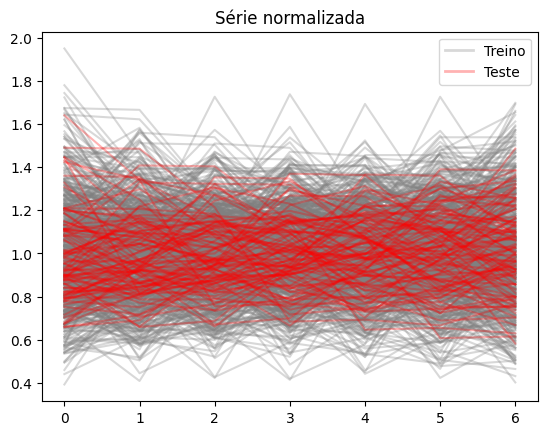

In [4]:
# | code-fold: true

_X = [x / x.mean() for x in _X]
_X_test = [x / x.mean() for x in _X_test]

fig, ax = plt.subplots()
for x in _X:
    ax.plot(x, color="gray", alpha=0.3)
for x in _X_test:
    ax.plot(x, color="red", alpha=0.3)

ax.legend(handles=legend_handles, loc="best")
ax.set_title("Série normalizada")
fig.show()

e podemos prever sem problemas.

Outra possibilidade é a diferenciação, como já vimos em capítulos anteriores. A diferenciação remove a tendência da série, tornando-a estacionária.

## Usando modelos de ML com sktime

Primeiro, vamos import `ReductionForecaster`, que é a classe que implementa a abordagem de janelas deslizantes para usar modelos de ML em séries temporais. Vamos testar um primeiro caso sem nenhum tipo de preprocessamento, apenas criando as janelas:

In [5]:
from tsbook.forecasting.reduction import ReductionForecaster
from lightgbm import LGBMRegressor

model = ReductionForecaster(
    LGBMRegressor(n_estimators=100, random_state=42),
    window_length=30,
)

model.fit(y_train, X=X_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7652
[LightGBM] [Info] Number of data points in the train set: 1618, number of used features: 31
[LightGBM] [Info] Start training from score 580.233004


ReductionForecaster(estimator=LGBMRegressor(random_state=42), window_length=30)

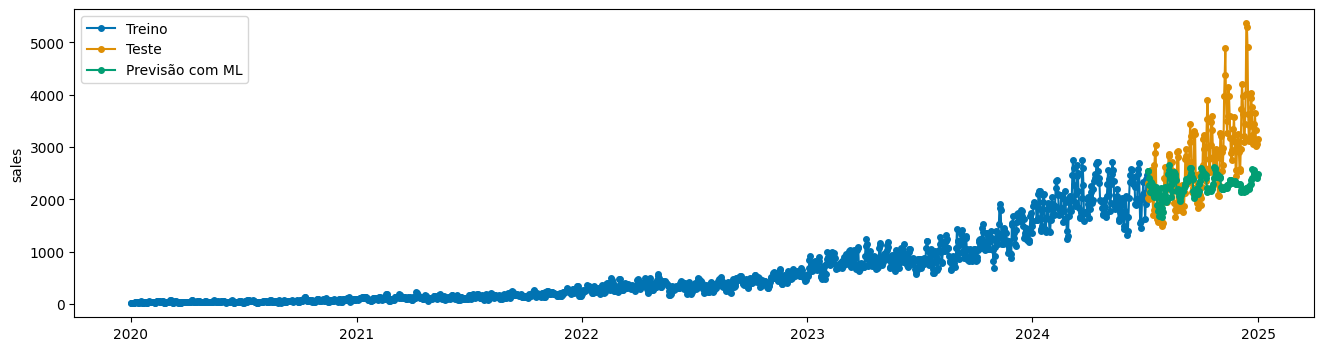

In [6]:
y_pred = model.predict(fh=y_test.index, X=X_test)
plot_series(y_train, y_test, y_pred, labels=["Treino", "Teste", "Previsão com ML"])
plt.show()

Claramente, tivemos o problema que mencionamos anteriormente.


### Solução 1: Diferenciação

Uma solução é usar a diferenciação para remover a tendência da série. 

In [7]:
from sktime.transformations.series.difference import Differencer

regressor = LGBMRegressor(n_estimators=100, random_state=42)

model = Differencer() * ReductionForecaster(
    regressor,
    window_length=30,
    steps_ahead=1,
)

model.fit(y_train, X=X_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7642
[LightGBM] [Info] Number of data points in the train set: 1618, number of used features: 31
[LightGBM] [Info] Start training from score 1.495674


TransformedTargetForecaster(steps=[Differencer(),
                                   ReductionForecaster(estimator=LGBMRegressor(random_state=42),
                                                       window_length=30)])

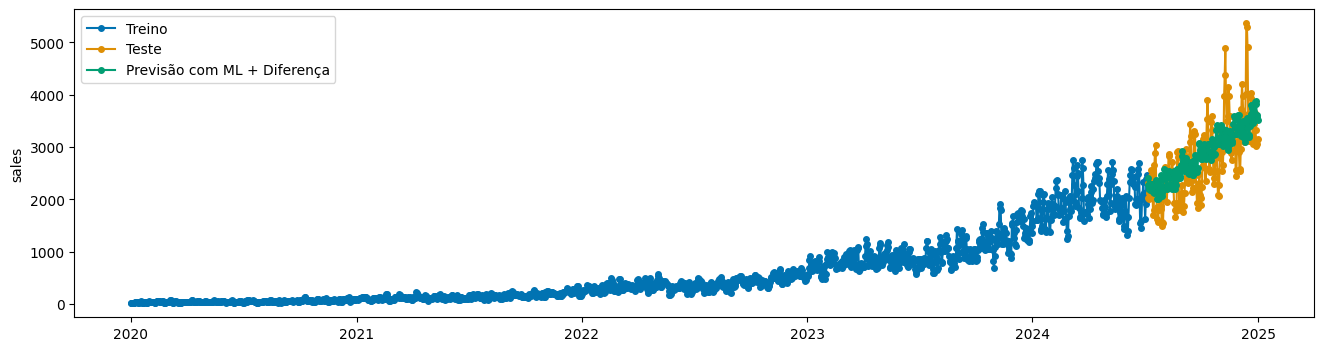

In [8]:
y_pred_diff = model.predict(fh=y_test.index, X=X_test)

plot_series(
    y_train, y_test, y_pred_diff, labels=["Treino", "Teste", "Previsão com ML + Diferença"]
)
plt.show()

Aqui, já vemos uma melhora significativa. Mas tem algo que podemos melhorar para realizar a diferenciação? Sim. Lembre que essa série tem um padrão multiplicativo. Então, antes de aplicar a diferenciação, podemos aplicar uma transformação logarítmica para estabilizar a variância:

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7652
[LightGBM] [Info] Number of data points in the train set: 1618, number of used features: 31
[LightGBM] [Info] Start training from score 0.002516


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

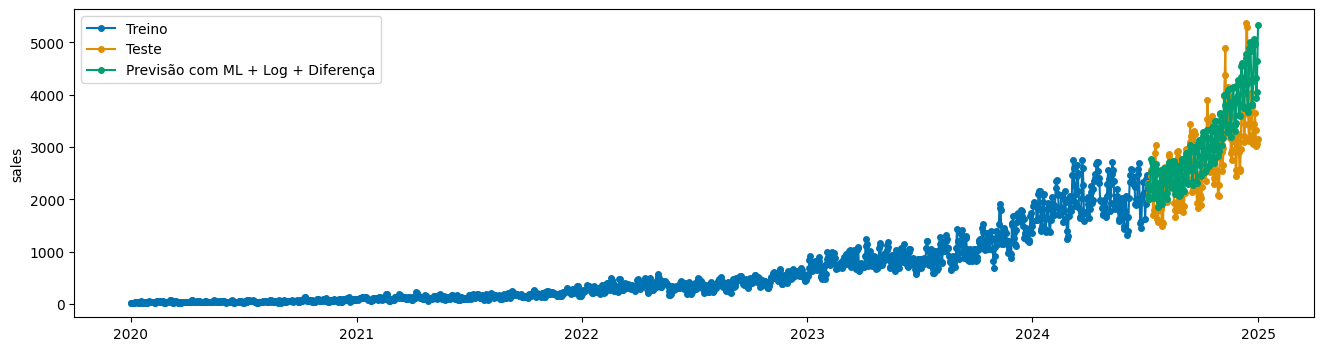

In [9]:
from sktime.transformations.series.boxcox import LogTransformer

model_log = LogTransformer() * model

model_log.fit(y_train, X=X_train)
y_pred_log_diff = model_log.predict(fh=y_test.index, X=X_test)
plot_series(
    y_train,
    y_test,
    y_pred_log_diff,
    labels=["Treino", "Teste", "Previsão com ML + Log + Diferença"],
)

### Solução 2: Normalização por janela

A diferenciação aumenta o ruído da série, o que pode dificultar o trabalho do modelo de ML. Outra opção é normalizar em cada janela. A classe `ReductionForecaster` tem um parâmetro chamado `normalization_strategy`, que pode ser usado para determinar a estratégia de normalização. Vamos usar a estratégia `divide_mean`, que divide cada janela pelo seu valor médio.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7652
[LightGBM] [Info] Number of data points in the train set: 1618, number of used features: 31
[LightGBM] [Info] Start training from score 1.043509


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

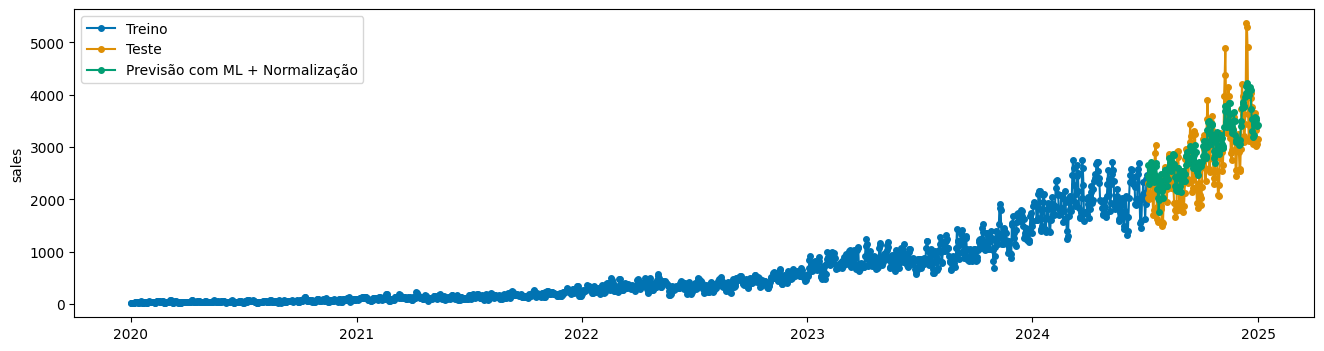

In [10]:
model = ReductionForecaster(
    regressor,
    window_length=30,
    steps_ahead=1,
    normalization_strategy="divide_mean",
)

model.fit(y_train, X=X_train)
y_pred_norm = model.predict(fh=y_test.index, X=X_test)

plot_series(
    y_train, y_test, y_pred_norm, labels=["Treino", "Teste", "Previsão com ML + Normalização"]
)

### Modelo direto e recursivo

Podemos fazer um conjunto de modelos, um para cada passo à frente. Abaixo, definimos `steps_ahead=12`, o que significa que o modelo vai prever 12 passos à frente diretamente.

In [11]:
model = ReductionForecaster(
    regressor,
    window_length=30,
    steps_ahead=12,
    normalization_strategy="divide_mean",
)

model.fit(y_train, X=X_train)
y_pred_norm_direct = model.predict(fh=y_test.index, X=X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7652
[LightGBM] [Info] Number of data points in the train set: 1618, number of used features: 31
[LightGBM] [Info] Start training from score 1.043509
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7652
[LightGBM] [Info] Number of data points in the train set: 1617, number of used features: 31
[LightGBM] [Info] Start training from score 1.047248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7652
[LightGBM] [Info] Number of data points in the train set: 1616, number of used features: 31
[LightGBM] [Info] Start traini

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

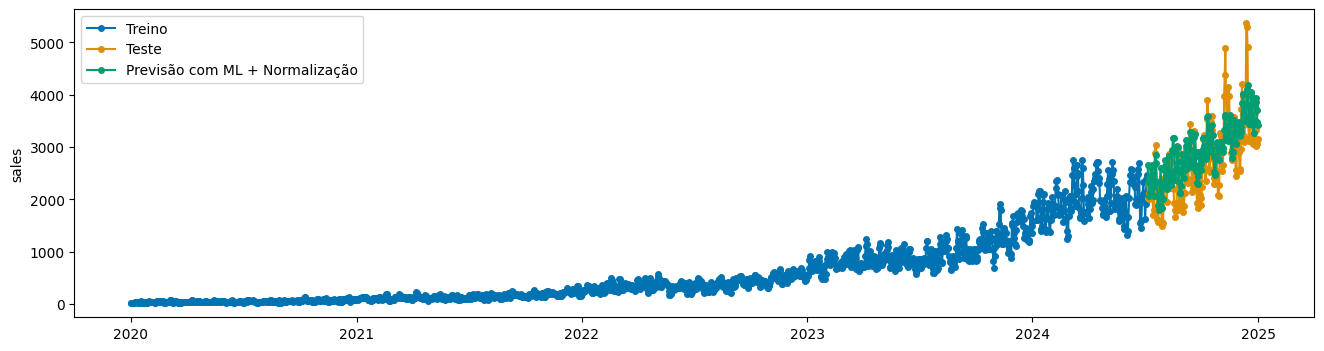

In [12]:
plot_series(
    y_train,
    y_test,
    y_pred_norm_direct,
    labels=["Treino", "Teste", "Previsão com ML + Normalização"],
)

Podemos comparar o MAPE de todos os modelos:

In [13]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

mape = MeanAbsolutePercentageError()

results = {}
for _y_pred, label in zip(
    [
        y_pred,
        y_pred_diff,
        y_pred_log_diff,
        y_pred_norm,
        y_pred_norm_direct,
    ],
    [
        "ML",
        "ML + Diferença",
        "ML + Log + Diferença",
        "ML + Normalização",
        "ML + Normalização + Direto",
    ],
):
    results[label] = mape(y_test, _y_pred)

import pandas as pd

results = pd.DataFrame.from_dict(results, orient="index", columns=["MAPE"])
results.sort_values("MAPE")

,MAPE
ML + Normalização + Direto,0.136547
ML + Normalização,0.145583
ML + Diferença,0.164518
ML + Log + Diferença,0.174632
ML,0.202821
